In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

In [49]:
from lifelines import CoxPHFitter

In [50]:
df = pd.read_csv('data/Fancy_data.csv')

In [51]:
df.head(5)

,SeniorCitizen,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,RobustOutlier,Ease_of_Payment,FamilyResponsibility,TotalServices,CommunicationServices,OnlineServices,EntertainmentServices,Loyalty
0,0,1,1,29.85,29.85,0,False,2,1,2,0,1,0,0
1,0,34,0,56.95,1889.50,0,False,1,0,4,1,1,0,1
2,0,2,1,53.85,108.15,1,False,1,0,4,1,1,0,0
3,0,45,0,42.30,1840.75,0,False,4,0,4,0,1,0,1
4,0,2,1,70.70,151.65,1,False,2,0,2,1,0,0,0


In [52]:
y = df['TotalServices']
df.drop(['RobustOutlier','TotalServices'],inplace=True,axis=1)

In [53]:
# Making a train-test split
X_train, X_test, _, _ = train_test_split(
    df,y, test_size=0.33, random_state=42)

In [54]:
cph = CoxPHFitter()
cph.fit(X_train, duration_col='tenure', event_col='Churn',robust=True)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4696 total observations, 3442 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
          robust variance = True
      baseline estimation = breslow
   number of observations = 4696
number of events observed = 1254
   partial log-likelihood = -8049.10
         time fit was run = 2024-11-10 12:57:09 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
SeniorCitizen         -0.05      0.95      0.06           -0.17            0.06                0.85                1.07
PaperlessBilling       0.21      1.23      0.07            0.08            0.34                1.08                1.41
MonthlyCharges         0.06      1.07      0.00            0.06            0.07                1.06                1.07
TotalCharges          -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Ease_of_Payment       -0.18      0.84      0.03           -0.23           -0.13                0.80                0.88
FamilyResponsibility  -0.22      0.81      0.05           -0.32           -0.11                0.73                0.90
CommunicationServices -0.67      0.51      0.16           -0.98           -0.36                0.38                0.70
OnlineServices        -0.44      0.64      0.06           -0.56           -0.33                0.57                0.72
EntertainmentServices -0.45      0.64      0.07           -0.60           -0.31                0.55                0.73
Loyalty               -1.87      0.15      0.11           -2.09           -1.65                0.12                0.19

                       cmp to      z      p  -log2(p)
covariate                                            
SeniorCitizen            0.00  -0.87   0.39      1.38
PaperlessBilling         0.00   3.16 <0.005      9.33
MonthlyCharges           0.00  20.33 <0.005    302.85
TotalCharges             0.00 -27.67 <0.005    557.58
Ease_of_Payment          0.00  -6.74 <0.005     35.85
FamilyResponsibility     0.00  -4.02 <0.005     14.06
CommunicationServices    0.00  -4.24 <0.005     15.44
OnlineServices           0.00  -7.68 <0.005     45.79
EntertainmentServices    0.00  -6.22 <0.005     30.90
Loyalty                  0.00 -16.76 <0.005    207.00
---
Concordance = 0.92
Partial AIC = 16118.20
log-likelihood ratio test = 3875.16 on 10 df
-log2(p) of ll-ratio test = inf

<Axes: xlabel='log(HR) (95% CI)'>

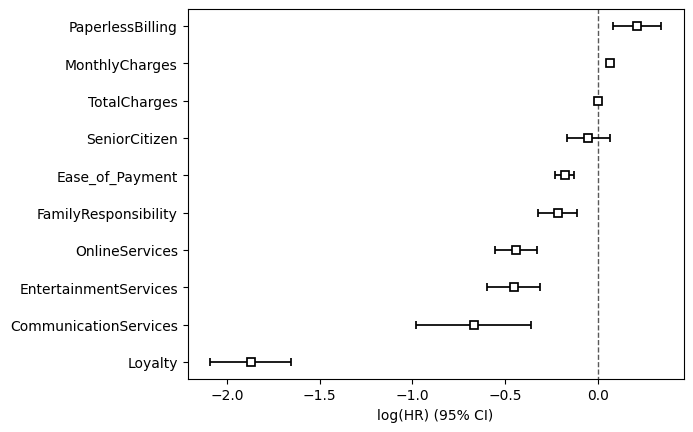

In [55]:
cph.plot()

In [56]:
X_test.shape

(2314, 12)

In [57]:
def risk_period(preds,threshold=0.5):
    indices = preds.index
    
    def fun(x):
        for i in range(len(x)):
            if x.iloc[i] <= threshold:
                return indices[i]
        return 72
    
    return pd.DataFrame({"Expected Time to Churn" : preds.apply(fun,axis=0)})

In [58]:
preds = cph.predict_survival_function(X_train)
risk_period(preds,0.5)

,Expected Time to Churn
5719,16.0
2821,68.0
229,72.0
6150,43.0
4747,72.0
...,...
3772,68.0
5191,67.0
5226,3.0
5390,72.0


<Axes: >

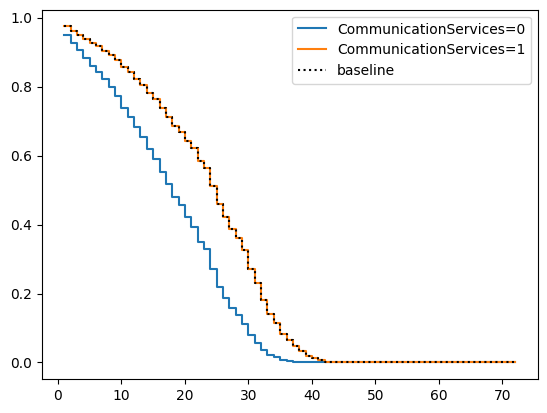

In [59]:
cph.plot_partial_effects_on_outcome(
    covariates=["CommunicationServices"],
    values=[0,1]
)

In [60]:
cph.check_assumptions(X_train,p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 4696 total observations, 3442 right-censored observations>
         test_name = proportional_hazard_test

---
                            test_statistic      p  -log2(p)
CommunicationServices km              5.97   0.01      6.11
                      rank            4.12   0.04      4.56
Ease_of_Payment       km              0.12   0.73      0.45
                      rank            0.47   0.49      1.02
EntertainmentServices km              4.43   0.04      4.82
                      rank            3.07   0.08      3.65
FamilyResponsibility  km              0.12   0.73      0.45
                      rank            0.22   0.64      0.65
Loyalty               km             75.96 <0.005     58.26
                      rank           62.44 <0.005     48.37
MonthlyCharges        km            117.54 <0.005     88.57
                      rank          151.69 <0.005    113.38
OnlineServices        km              1.68   0.20      2.36
                      rank            0.21   0.65      0.62
PaperlessBilling      km              0.38   0.54      0.90
                      rank            0.60   0.44      1.19
SeniorCitizen         km              5.72   0.02      5.90
                      rank            2.68   0.10      3.29
TotalCharges          km            132.79 <0.005     99.65
                      rank           35.34 <0.005     28.43



1. Variable 'SeniorCitizen' failed the non-proportional test: p-value is 0.0167.

   Advice: with so few unique values (only 2), you can include `strata=['SeniorCitizen', ...]` in
the call in `.fit`. See documentation in link [E] below.

2. Variable 'MonthlyCharges' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'MonthlyCharges' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'MonthlyCharges' using pd.cut, and then specify it in
`strata=['MonthlyCharges', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


3. Variable 'TotalCharges' failed the non-proportional test: p-value is <5e-05.

   Advice 1

[]

In [61]:
cph = CoxPHFitter()
cph.fit(X_train, duration_col='tenure', event_col='Churn',strata = ['CommunicationServices','EntertainmentServices','Loyalty'],robust=True)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4696 total observations, 3442 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
          robust variance = True
                   strata = ['CommunicationServices', 'EntertainmentServices', 'Loyalty']
      baseline estimation = breslow
   number of observations = 4696
number of events observed = 1254
   partial log-likelihood = -6036.74
         time fit was run = 2024-11-10 12:57:15 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
SeniorCitizen         0.02      1.02      0.06           -0.09            0.14                0.92                1.15
PaperlessBilling      0.27      1.31      0.07            0.14            0.40                1.15                1.50
MonthlyCharges        0.08      1.09      0.00            0.08            0.09                1.08                1.10
TotalCharges         -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Ease_of_Payment      -0.12      0.89      0.03           -0.17           -0.07                0.84                0.94
FamilyResponsibility -0.21      0.81      0.05           -0.32           -0.10                0.73                0.90
OnlineServices       -0.51      0.60      0.06           -0.62           -0.40                0.54                0.67

                      cmp to      z      p  -log2(p)
covariate                                           
SeniorCitizen           0.00   0.43   0.67      0.59
PaperlessBilling        0.00   4.00 <0.005     13.94
MonthlyCharges          0.00  20.43 <0.005    305.77
TotalCharges            0.00 -28.87 <0.005    606.52
Ease_of_Payment         0.00  -4.43 <0.005     16.67
FamilyResponsibility    0.00  -3.83 <0.005     12.95
OnlineServices          0.00  -8.86 <0.005     60.06
---
Concordance = 0.90
Partial AIC = 12087.47
log-likelihood ratio test = 3007.47 on 7 df
-log2(p) of ll-ratio test = inf

<Axes: xlabel='log(HR) (95% CI)'>

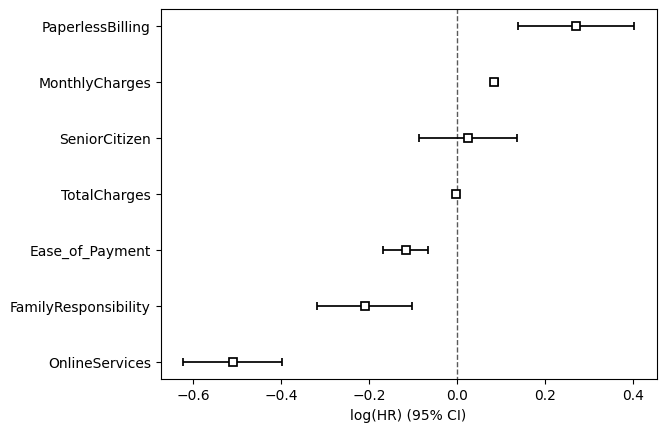

In [62]:
cph.plot()

In [64]:
cph.check_assumptions(X_train,p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 4696 total observations, 3442 right-censored observations>
         test_name = proportional_hazard_test

---
                           test_statistic      p  -log2(p)
Ease_of_Payment      km              0.88   0.35      1.53
                     rank            0.70   0.40      1.31
FamilyResponsibility km              0.10   0.75      0.42
                     rank            0.00   0.96      0.06
MonthlyCharges       km            152.65 <0.005    114.08
                     rank          122.99 <0.005     92.53
OnlineServices       km             15.05 <0.005     13.22
                     rank           23.29 <0.005     19.46
PaperlessBilling     km              0.27   0.60      0.74
                     rank            0.37   0.55      0.88
SeniorCitizen        km              1.94   0.16      2.61
                     rank            6.32   0.01      6.39
TotalCharges         km             94.24 <0.005     71.60
                     rank            4.47   0.03      4.86



1. Variable 'SeniorCitizen' failed the non-proportional test: p-value is 0.0119.

   Advice: with so few unique values (only 2), you can include `strata=['SeniorCitizen', ...]` in
the call in `.fit`. See documentation in link [E] below.

2. Variable 'MonthlyCharges' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'MonthlyCharges' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'MonthlyCharges' using pd.cut, and then specify it in
`strata=['MonthlyCharges', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


3. Variable 'TotalCharges' failed the non-proportional test: p-value is <5e-05.

   Advice 1

[]

In [65]:
covs = [x for x in X_train.columns if x not in ['tenure','Churn','TotalCharges']]

X_new = X_train.drop(['TotalCharges'],axis=1)
cph = CoxPHFitter()
cph.fit(X_new, duration_col='tenure',event_col='Churn',strata = ['SeniorCitizen','CommunicationServices','EntertainmentServices','OnlineServices','Loyalty'],robust=True)

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4696 total observations, 3442 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
          robust variance = True
                   strata = ['SeniorCitizen', 'CommunicationServices', 'EntertainmentServices', 'OnlineServices', 'Loyalty']
      baseline estimation = breslow
   number of observations = 4696
number of events observed = 1254
   partial log-likelihood = -5967.60
         time fit was run = 2024-11-10 12:57:39 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
PaperlessBilling      0.30      1.35      0.07            0.16            0.43                1.17                1.54
MonthlyCharges        0.01      1.01      0.00            0.01            0.01                1.01                1.01
Ease_of_Payment      -0.22      0.81      0.03           -0.27           -0.16                0.76                0.85
FamilyResponsibility -0.50      0.61      0.06           -0.62           -0.38                0.54                0.68

                      cmp to     z      p  -log2(p)
covariate                                          
PaperlessBilling        0.00  4.25 <0.005     15.48
MonthlyCharges          0.00  4.77 <0.005     19.06
Ease_of_Payment         0.00 -8.03 <0.005     49.87
FamilyResponsibility    0.00 -8.25 <0.005     52.47
---
Concordance = 0.62
Partial AIC = 11943.21
log-likelihood ratio test = 175.35 on 4 df
-log2(p) of ll-ratio test = 120.01

<Axes: xlabel='log(HR) (95% CI)'>

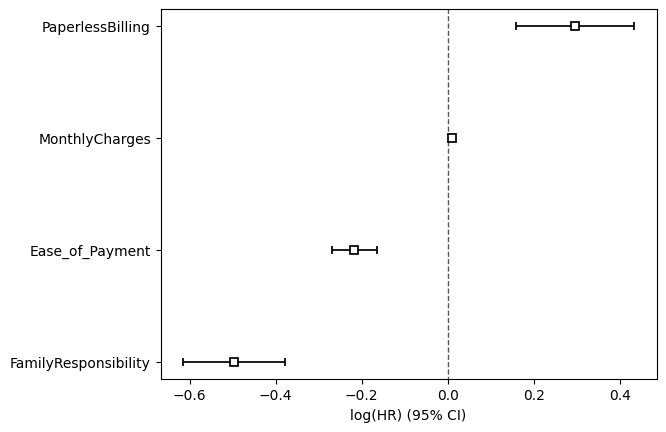

In [66]:
cph.plot()

<Axes: ylabel='Frequency'>

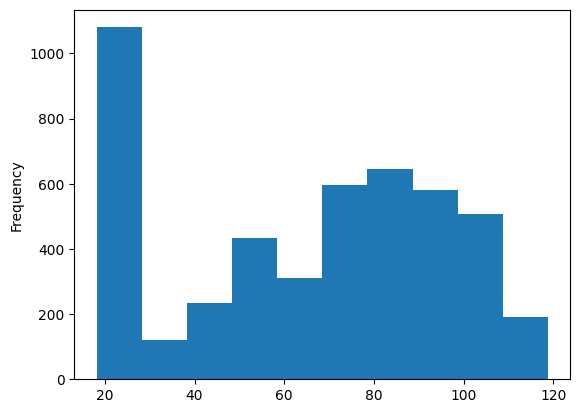

In [67]:
X_train['MonthlyCharges'].plot(kind='hist')

<Axes: >

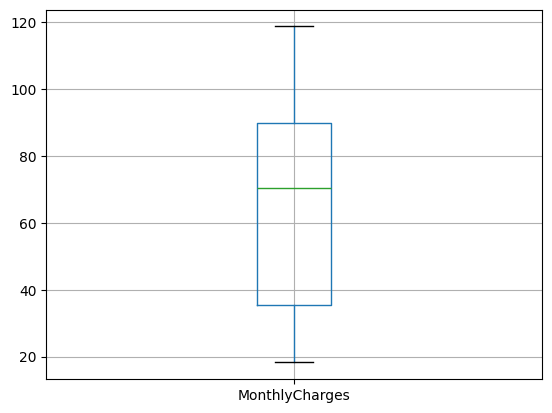

In [68]:
X_train.boxplot(column='MonthlyCharges')

In [69]:
X_test

,SeniorCitizen,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Ease_of_Payment,FamilyResponsibility,CommunicationServices,OnlineServices,EntertainmentServices,Loyalty
6850,1,71,1,99.65,7181.25,0,4,0,1,1,1,1
6723,0,12,0,49.85,552.10,0,1,0,0,1,1,2
245,1,4,0,75.35,273.40,0,2,0,1,1,0,0
1880,0,14,1,31.10,419.70,0,1,0,0,1,0,0
6798,0,35,1,20.20,684.40,0,1,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
298,0,40,1,74.55,3015.75,0,2,1,1,1,1,0
3295,0,15,0,25.20,387.90,0,1,1,1,0,0,2
5934,1,18,0,78.55,1422.65,1,2,1,1,0,1,0
2614,0,17,1,66.70,1077.05,0,1,1,1,1,0,0


In [70]:
X_test_new = X_test.drop(['TotalCharges'],axis=1)
final_prediction = cph.predict_survival_function(X_test_new)
final_prediction

,1934,3607,5469,185,1199,6951,5927,3491,4352,3246,...,2133,6695,6453,6157,2167,6078,4866,627,5692,3801
1.0,0.876381,0.838941,0.899502,0.867684,0.933445,0.933791,0.867805,0.791643,0.840854,0.792637,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2.0,0.853138,0.809460,0.880304,0.842958,0.920441,0.920851,0.843099,0.754848,0.811683,0.755990,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3.0,0.826354,0.775816,0.858051,0.814527,0.905243,0.905728,0.814691,0.713395,0.778374,0.714691,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4.0,0.797071,0.739443,0.833559,0.783524,0.888356,0.888921,0.783711,0.669245,0.742344,0.670690,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5.0,0.797071,0.739443,0.833559,0.783524,0.888356,0.888921,0.783711,0.669245,0.742344,0.670690,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68.0,0.477988,0.374407,0.552947,0.452051,0.680258,0.681667,0.452403,0.270620,0.379209,0.272526,...,0.985152,0.979725,0.981847,0.972313,0.983023,0.977713,0.981473,0.965355,0.983160,0.987005
69.0,0.477988,0.374407,0.552947,0.452051,0.680258,0.681667,0.452403,0.270620,0.379209,0.272526,...,0.969729,0.958783,0.963055,0.943937,0.965427,0.954742,0.962302,0.930108,0.965704,0.973480
70.0,0.477988,0.374407,0.552947,0.452051,0.680258,0.681667,0.452403,0.270620,0.379209,0.272526,...,0.969729,0.958783,0.963055,0.943937,0.965427,0.954742,0.962302,0.930108,0.965704,0.973480
71.0,0.477988,0.374407,0.552947,0.452051,0.680258,0.681667,0.452403,0.270620,0.379209,0.272526,...,0.969729,0.958783,0.963055,0.943937,0.965427,0.954742,0.962302,0.930108,0.965704,0.973480


In [71]:
risk_period(final_prediction)

,Expected Time to Churn
1934,29.0
3607,29.0
5469,72.0
185,29.0
1199,72.0
...,...
6078,72.0
4866,72.0
627,72.0
5692,72.0
